# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, 
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

In [6]:
# Set directories
assets.dir = "/nfs/lab/projects/COVID_mouse/assets/"
reference.dir = "/nfs/lab/projects/COVID_mouse/assets/BoneMarrowReference.rds"
snRNAseq.dir = "/nfs/lab/projects/COVID_mouse/seurat/5_clean.map/snRNAseq_mrg.clean.scTyped.rds"

reference.map.dir = "/nfs/lab/projects/COVID_mouse/5_clean.map/"

In [7]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
compartment.ls = unique(cell.markers$Compartment)
celltype.ls = unique(cell.markers$Celltype)
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = compartment.ls)
cell.markers$CellType = factor(cell.markers$Celltype,
                        levels = celltype.ls)

In [8]:
log_open(file_name = paste0(reference.map.dir, "reference_map-RNA.log"))

[1] "/nfs/lab/projects/COVID_mouse/5_clean.map/log/reference_map-RNA.log"

# Load assay

In [9]:
reference = readRDS(reference.dir)
reference = UpdateSeuratObject(reference)
reference$celltypes = reference@active.ident
reference

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Updating matrix keys for DimReduc 'pca'

Updating matrix keys for DimReduc 'tsne'

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in pca

Updating slots in tsne

Setting tsne DimReduc to global

Validating object structure for Assay 'RNA'

Validating object structure for DimReduc 'pca'

Validating object structure for DimReduc 'tsne'

Object representation is consistent with the most current Seurat version



An object of class Seurat 
16701 features across 7497 samples within 1 assay 
Active assay: RNA (16701 features, 2872 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, tsne

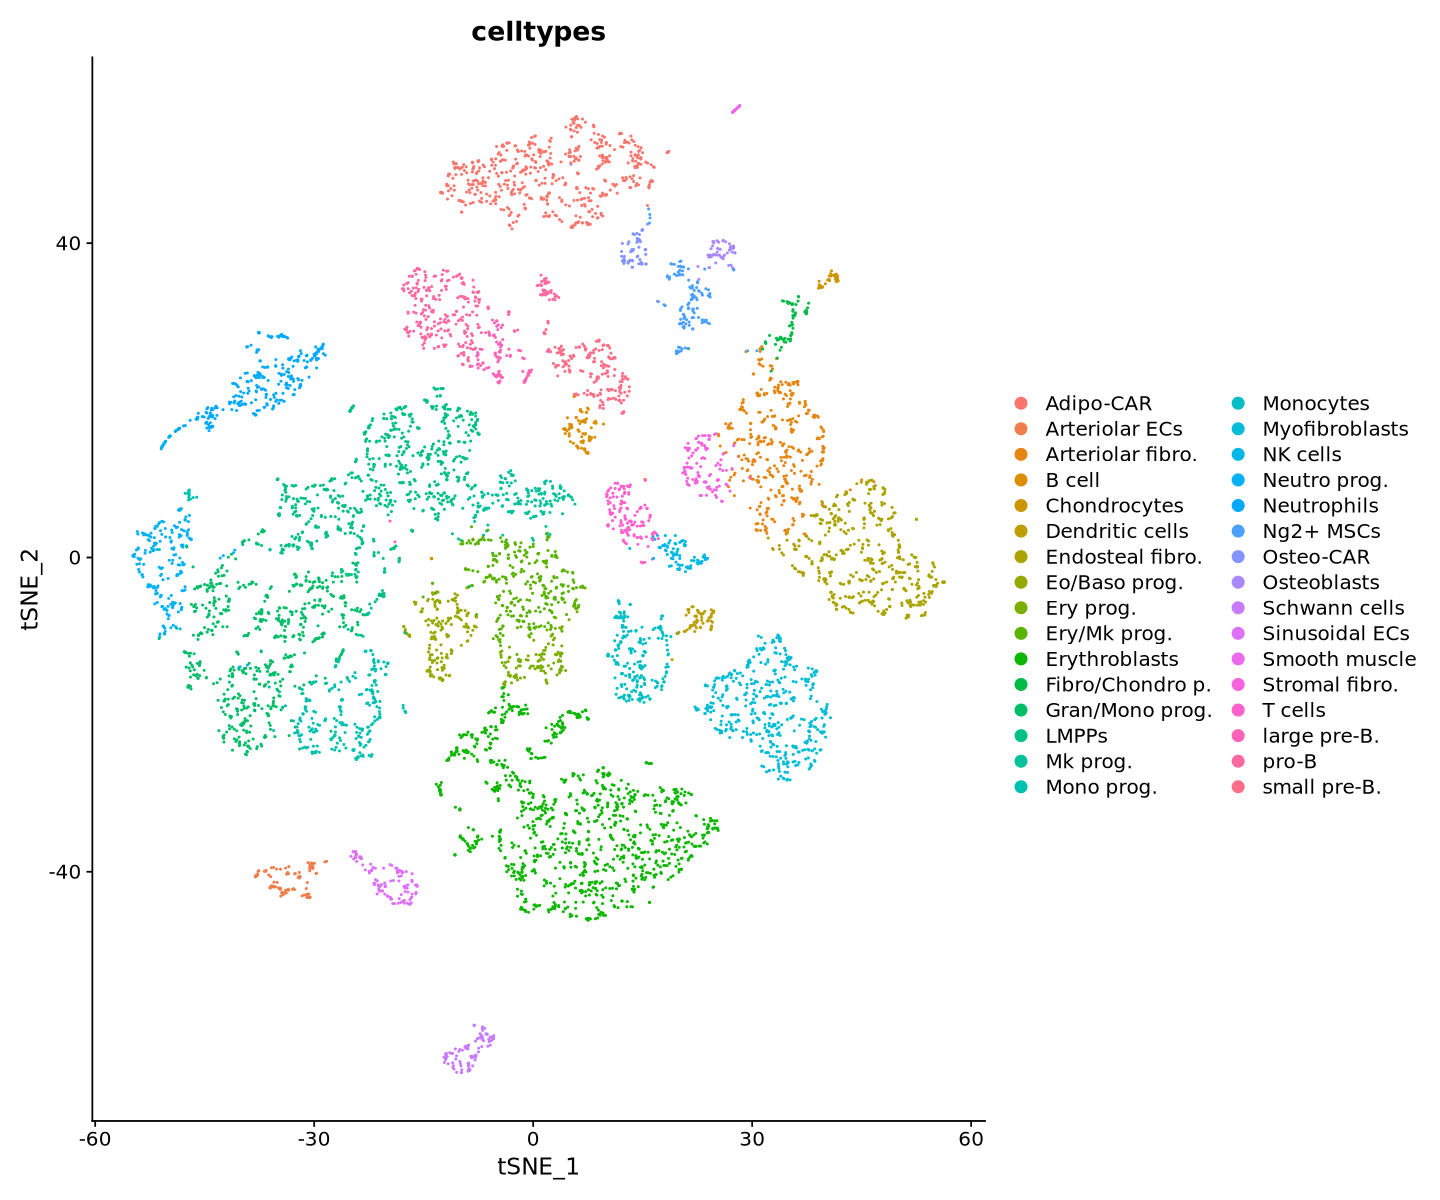

In [10]:
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(reference, group.by = "celltypes", reduction = "tsne")

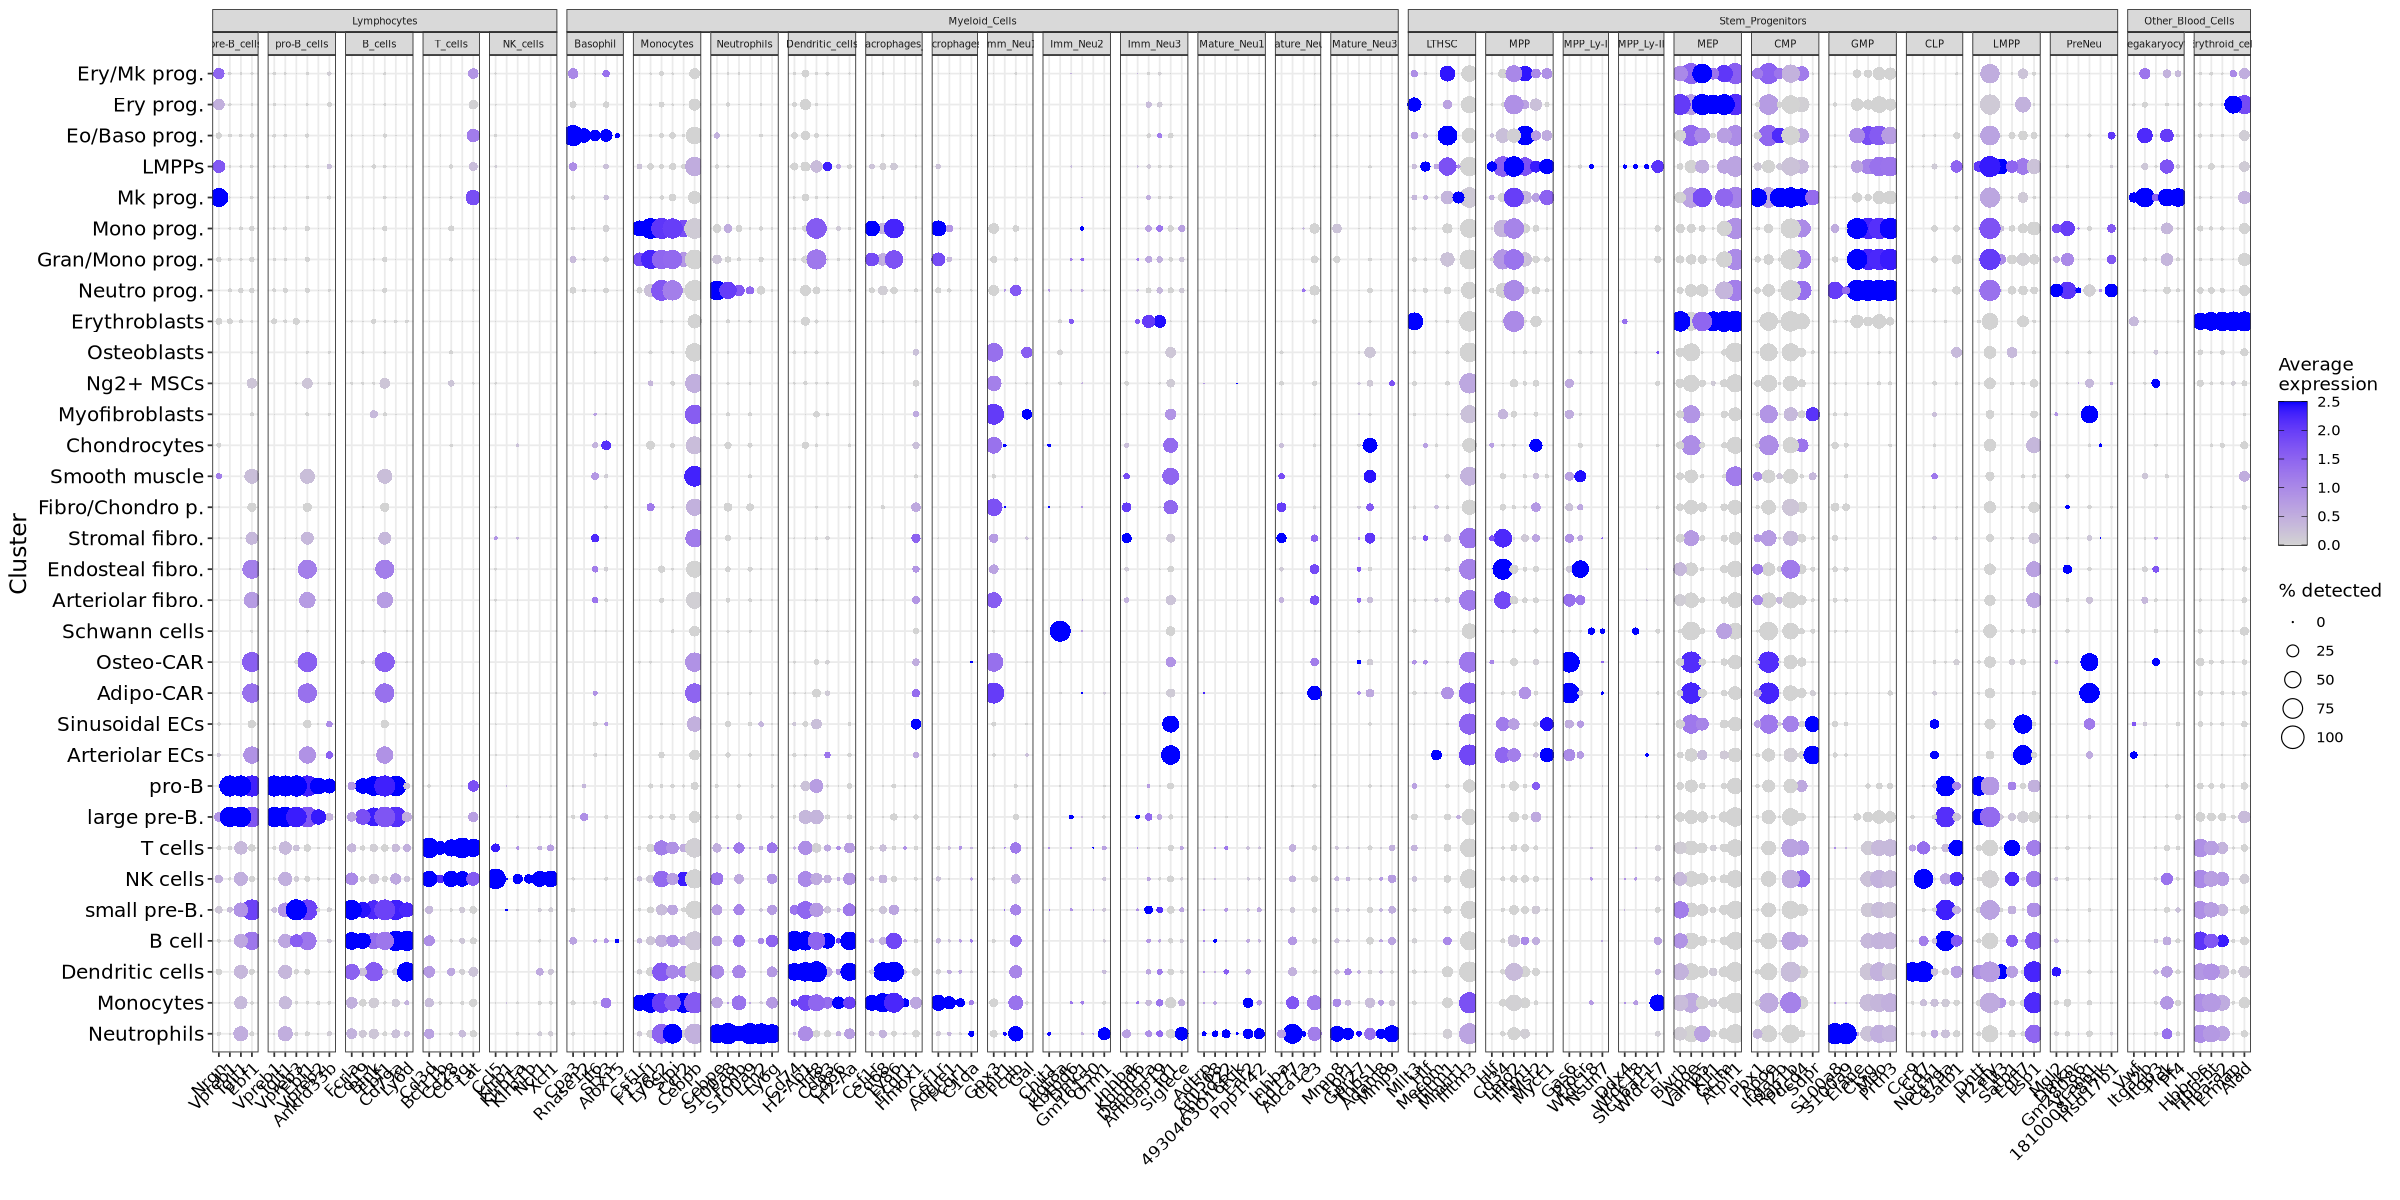

In [11]:
# Filter markers list for only genes present in the dataset
valid_features <- intersect(cell.markers$marker, rownames(reference[["RNA"]]))
g = DotPlot(reference, assay='RNA', features=valid_features, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=20, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 6),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

In [12]:
query = readRDS(snRNAseq.dir)

In [13]:
query

An object of class Seurat 
86047 features across 116182 samples within 3 assays 
Active assay: SCT (21477 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, RNA_raw
 3 dimensional reductions calculated: pca, harmony, umap

In [14]:
DefaultAssay(reference) <- "RNA"
DefaultAssay(query) <- "RNA"

# Format Metadata

In [15]:
# add relevant metadata columns before merging with the query
reference$technology = "snRNA"
query$technology = "snRNA"

# Reference map

In [16]:
query <- NormalizeData(query)
reference <- NormalizeData(reference)

In [17]:
# Computing sPCA transformation
reference <- FindVariableFeatures(reference, assay = 'RNA')
reference <- ScaleData(reference, assay = 'RNA')

Centering and scaling data matrix



In [18]:
reference <- FindNeighbors(
  object = reference,
  reduction = "pca",
  dims = 1:20,
  graph.name = "pca.annoy.neighbors", 
  k.param = 50,
  cache.index = TRUE,
  return.neighbor = TRUE,
  l2.norm = TRUE
)

Computing nearest neighbors

Only one graph name supplied, storing nearest-neighbor graph only



In [19]:
anchors <- FindTransferAnchors(
    reference = reference,
    query = query,
    k.filter = NA,
    reference.reduction = "pca", 
    reference.neighbors = "pca.annoy.neighbors", 
    dims = 1:20
)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 4466 anchors



In [20]:
# To address Error: The provided reduction.model does not have a model stored. Please try running umot-learn on the object first
# Need to rerun umap with the return.model=TRUE param
reference <- RunUMAP(reference, reduction = 'pca', dims = 1:20,
                     reduction.name = "umap.pca", reduction.key = "umap.pca_", return.model=TRUE)

UMAP will return its model

13:07:37 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

13:07:37 Read 7497 rows and found 20 numeric columns

13:07:37 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

13:07:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:07:38 Writing NN index file to temp file /nfs/lab/Luca/TMP/RtmpHx2u0A/filec497727b11b20

13:07:38 Searching Annoy index using 1 thread, search_k = 3000

13:07:41 Annoy recall = 100%

13:07:43 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:07:45 

In [21]:
query <- MapQuery(
    anchorset = anchors, 
    query = query,
    reference = reference, 
    refdata = list(
      celltypes = "celltypes"),
    reference.reduction = "pca",
    reduction.model = "umap.pca"
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

13:09:54 Read 116182 rows

13:09:54 Processing block 1 of 1

13:09:54 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:09:55 Initializing by weighted average of neighbor coordinates using 1 thread

13:09:55 Commencing optimization for 167 epochs, with 3485460 positive edges

13:10:50 Finished



In [22]:
#dim.reduction needs to be the same name for the merge
query@reductions$umap.pca_ <- query@reductions$ref.umap 

In [23]:
# visualize the results for individual objects
gg1 = DimPlot(reference, reduction = 'umap.pca',
              group.by = 'celltypes',
              label=TRUE, repel=TRUE) + NoLegend() + ggtitle("reference")
gg2 = DimPlot(query, reduction = 'ref.umap',
              group.by = 'predicted.celltypes',
              label=TRUE, repel=TRUE) + NoLegend() + ggtitle("query")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



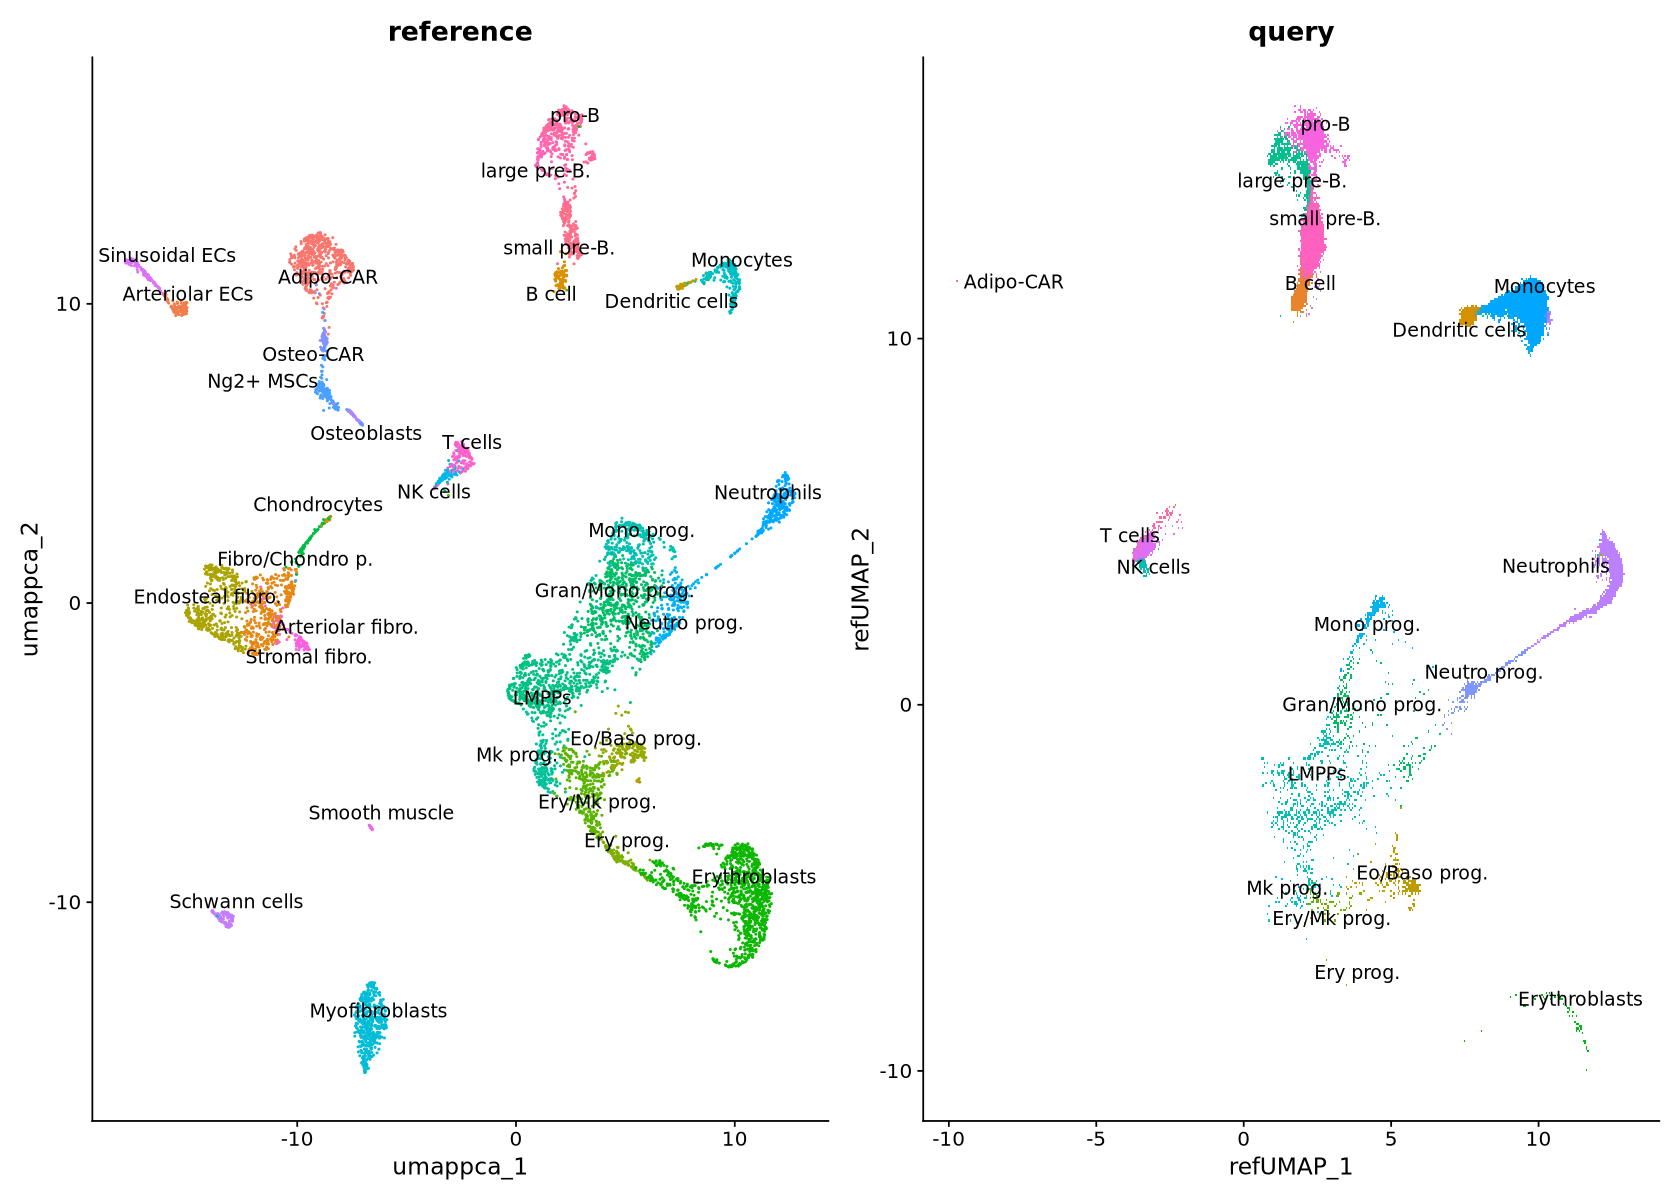

In [24]:
options(repr.plot.width=14, repr.plot.height=10)
gg1 + gg2

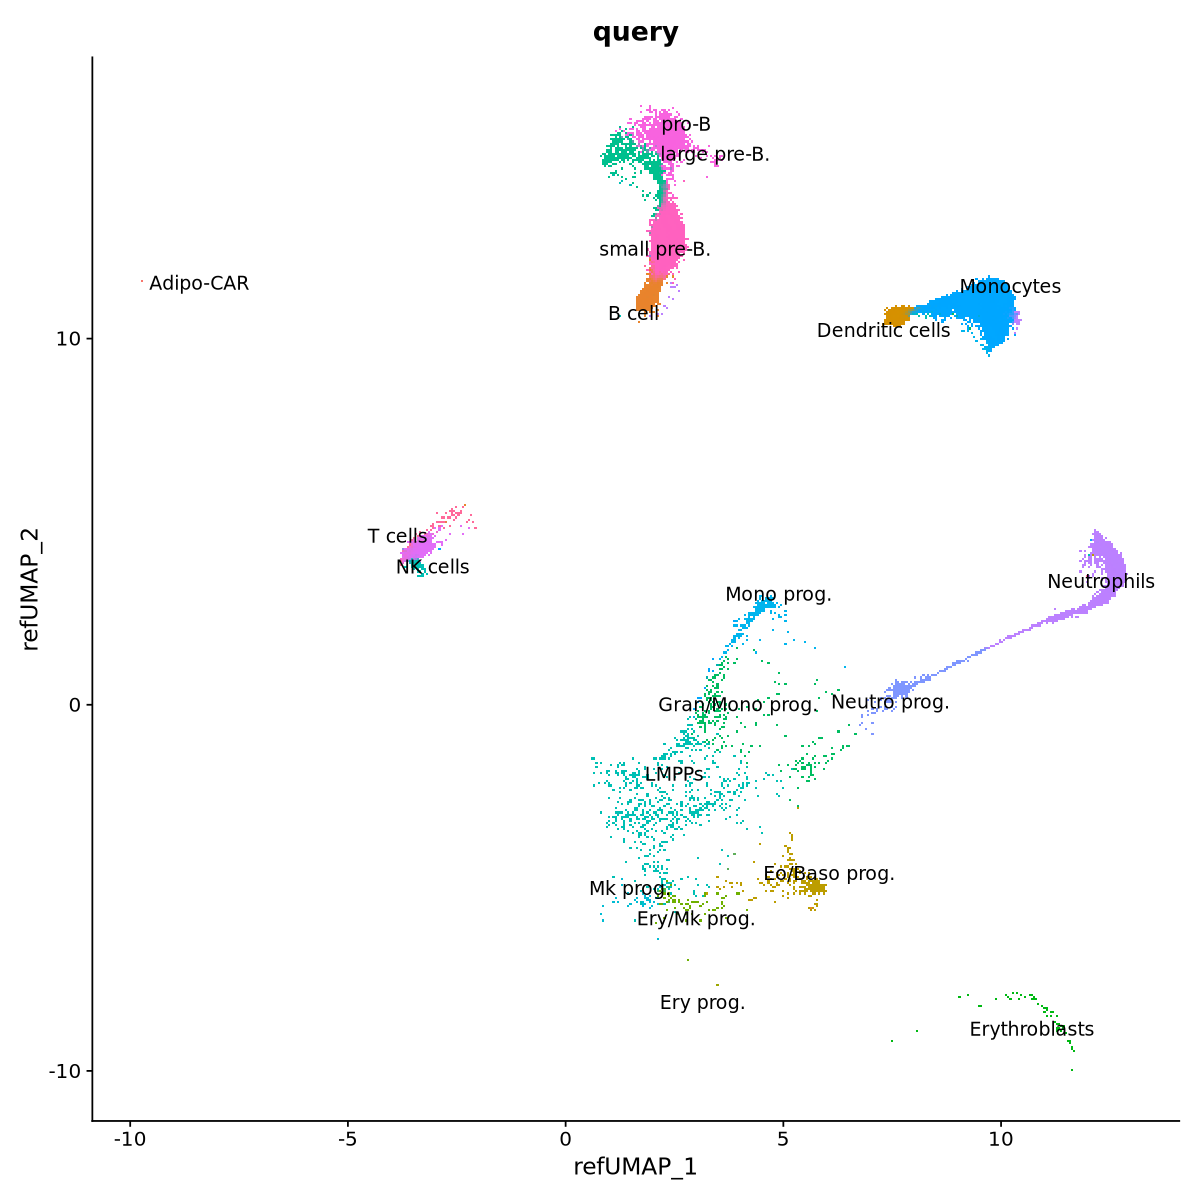

In [25]:
options(repr.plot.width=10, repr.plot.height=10)
gg2

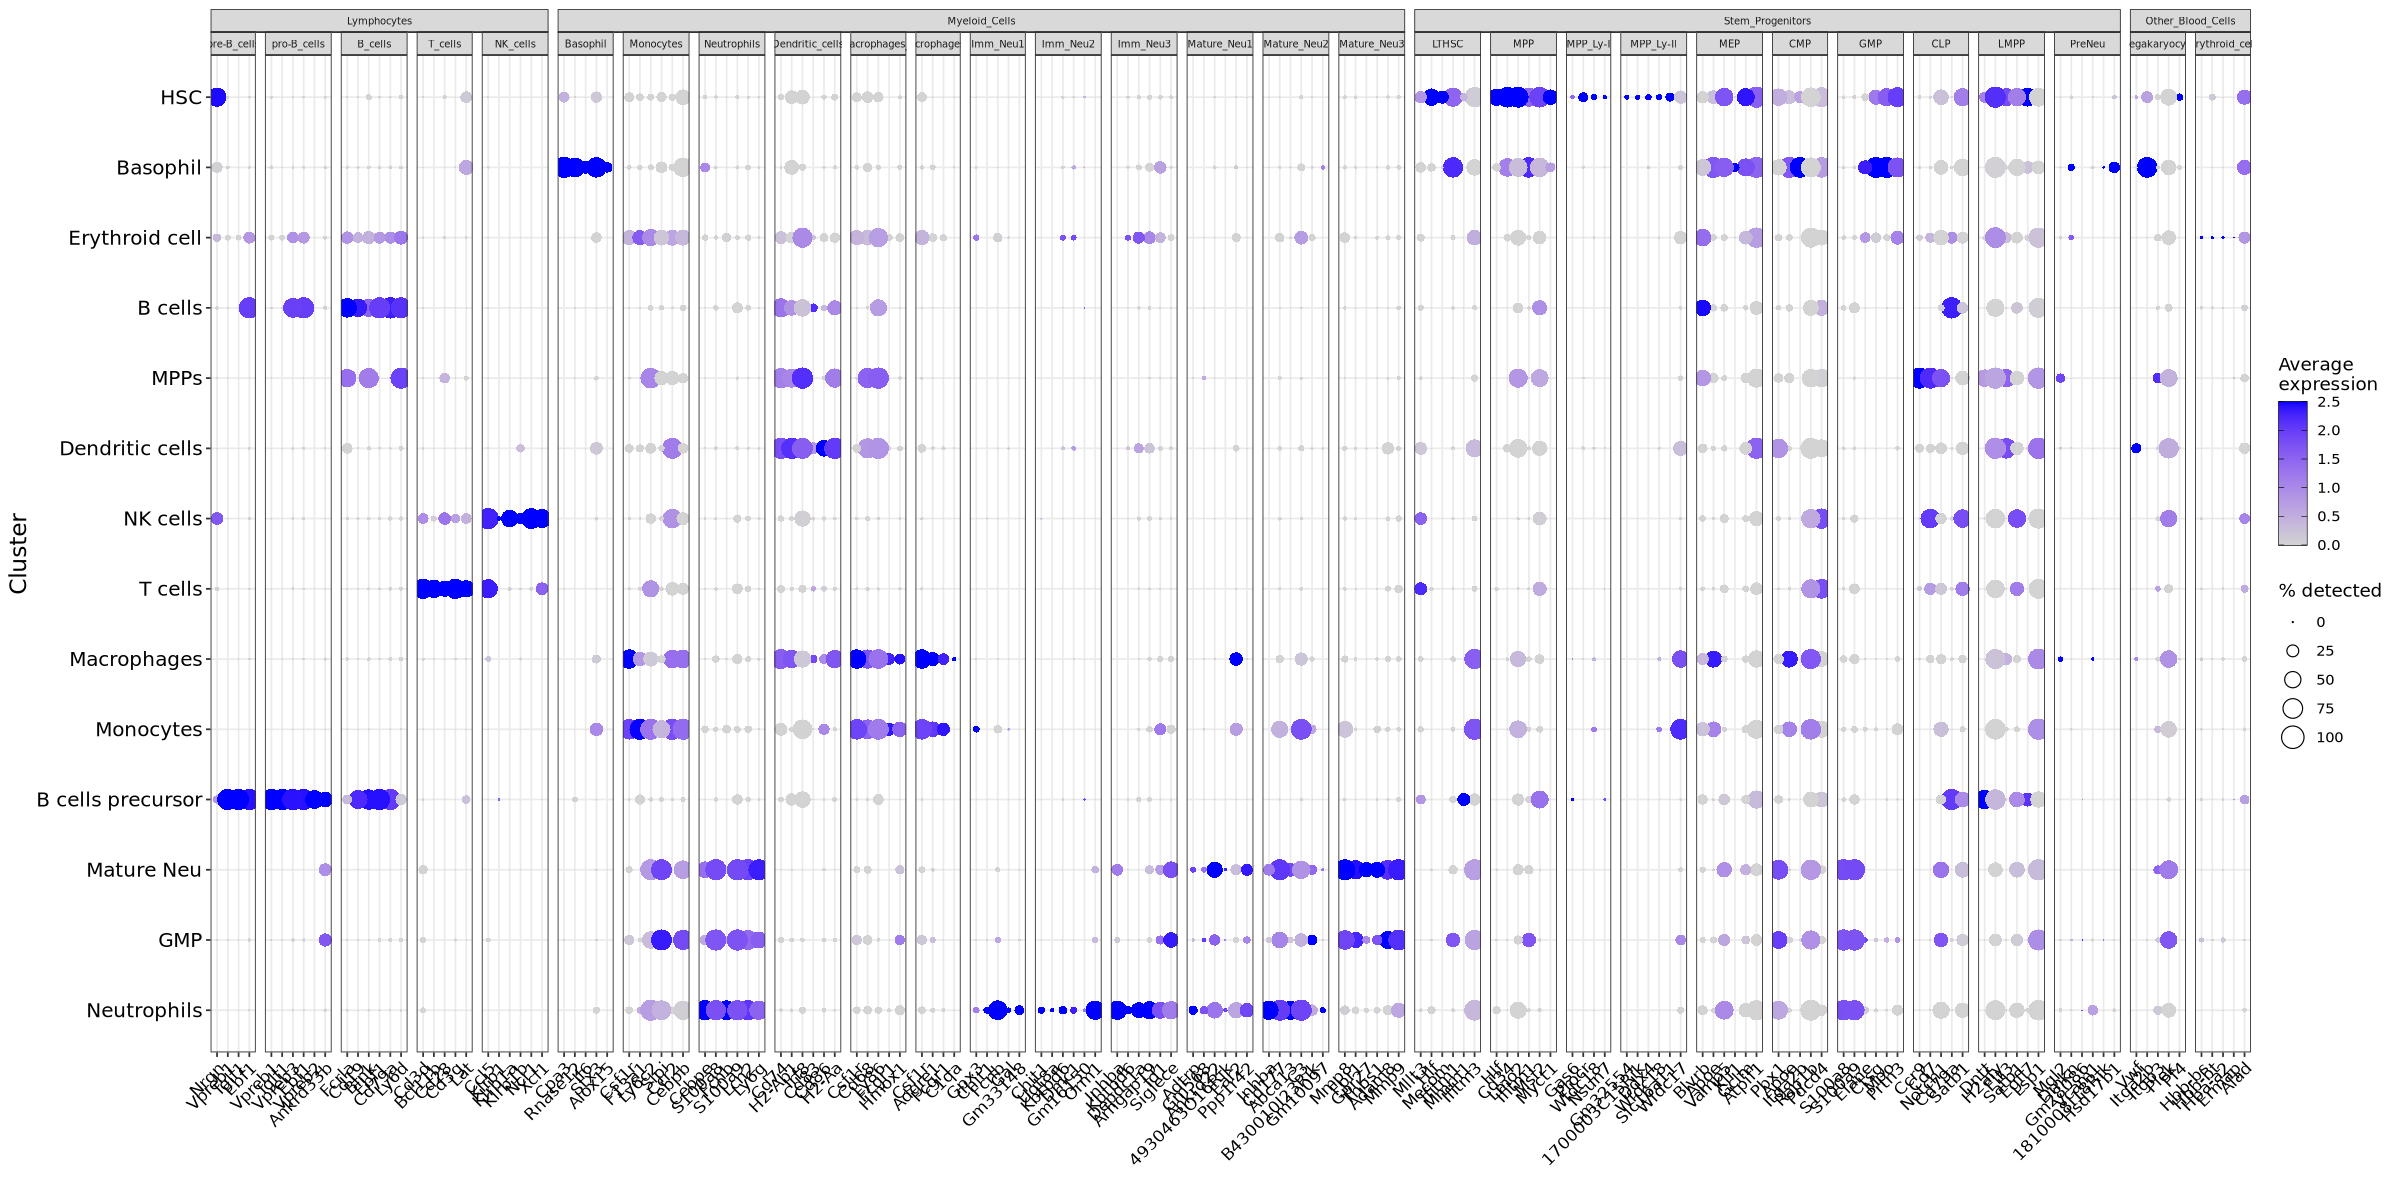

In [26]:
# Filter markers list for only genes present in the dataset
valid_features <- intersect(cell.markers$marker, rownames(query[["RNA"]]))
g = DotPlot(query, assay='RNA', features=valid_features, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=20, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 6),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [45]:
adata = query

# Filter data

In [46]:
# Violin plots of prediction score
celltype_scores <- FetchData(adata, vars = "predicted.celltypes.score")

# Calculate quantiles
quantiles <- quantile(celltype_scores$predicted.celltypes.score, probs = c(0.05, 0.10, 0.25))

In [47]:
quantiles

5%       10%       25% 
0.6882407 0.8434620 1.0000000

In [48]:
# Now create the violin plot
gg1 = ggplot(celltype_scores, aes(x = factor(1), y = predicted.celltypes.score)) +
  geom_violin(trim = FALSE) +
  labs(title = "Violin Plot of Predicted Cell Types Score",
       x = "",
       y = "\n Predicted Cell Types Score") +
  theme_bw() +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())+
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red")

# Now create the histogram
gg2 = ggplot(celltype_scores, aes(x = predicted.celltypes.score)) +
  geom_histogram(bins = 100, fill = "blue", color = "black") + # You can adjust the number of bins
  labs(title = "Histogram of Predicted Cell Types Score",
       x = " \n Predicted Cell Types Score",
       y = "Count") +
  theme_bw()+
  geom_vline(xintercept = 0.5, linetype = "dashed", color = "red")

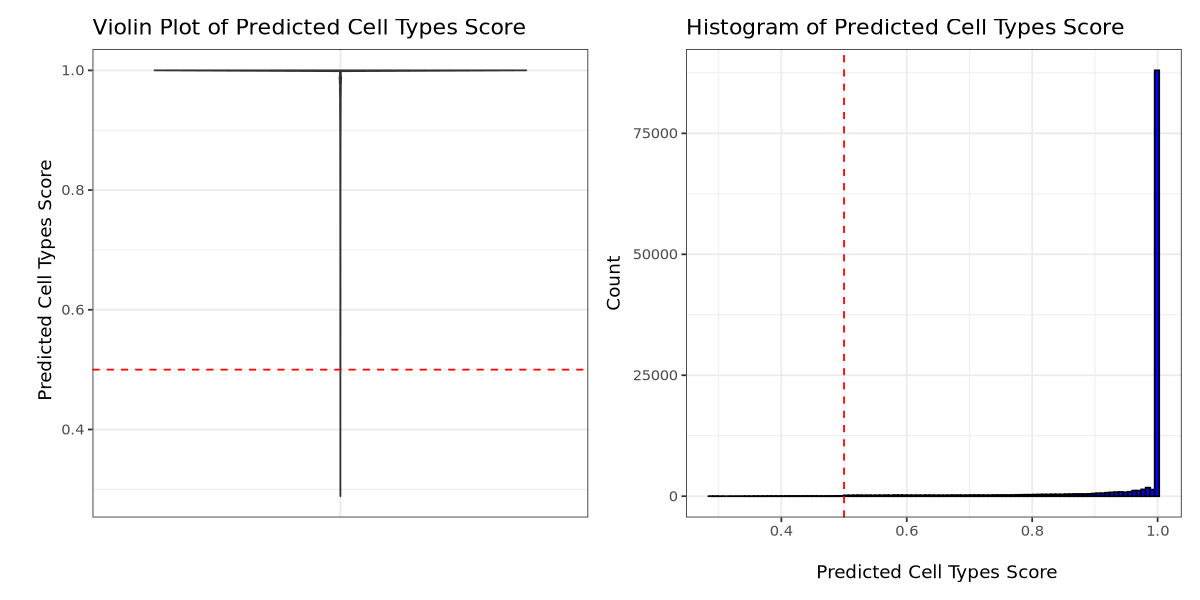

In [49]:
options(repr.plot.height = 5, repr.plot.width = 10)
gg1 + gg2

## Subset

In [50]:
tresh.use = 0.5

In [51]:
# quantile tresholding metadata
message("Quantile tresholding score : ", tresh.use)
reference.map.qc <- data.frame(barcode = names(Idents(adata)),
           predicted.celltypes = adata$predicted.celltypes,
           prediction.score = adata$predicted.celltypes.score)

reference.map.qc <- reference.map.qc %>%
  mutate(prediction.score.QC = if_else(reference.map.qc$prediction.score < tresh.use, 
                                 "Fail", "Pass"))
# Print results
 message("   - Cells removed by Prediction score QC: ", nrow(dplyr::filter(reference.map.qc, 
                                                                    prediction.score.QC == "Fail")))
cells.remove = dplyr::filter(reference.map.qc, prediction.score.QC == "Fail")

Quantile tresholding score : 0.5

   - Cells removed by Prediction score QC: 793



In [52]:
# Plot overall cell numbers
table = data.frame(table(adata$predicted.celltypes))
colnames(table) = c("celltypes", "freq")
# Remove 0s
table = dplyr::filter(table, freq != 0)
max(table$freq)

options(repr.plot.width=12, repr.plot.height=8)
gg1 = ggplot(table, aes(x = reorder(celltypes, +freq), y = freq, label = freq)) +
  geom_bar(stat = "identity", color = "black") +
  theme_bw() +
  labs(title = "Celltype numbers",
       x = "",
       y = " \n Frequency \n ") +
  ylim(0,70000)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  geom_text(hjust = -.5)+
  coord_flip()

# plot proportion of fail
table = data.frame(table(reference.map.qc$predicted.celltypes, reference.map.qc$prediction.score.QC))
colnames(table) = c("celltypes", "prediction.score.QC", "freq")
table = dplyr::filter(table, freq != 0)

options(repr.plot.width=8, repr.plot.height=8)
gg3 = ggplot(table, aes(x = reorder(celltypes, +freq), y = freq, fill = prediction.score.QC)) +
  geom_bar(stat = "identity", color = "black", position = position_fill()) +
  theme_bw() +
  labs(title = "Celltype/prediction.score.QC",
       x = "",
       y = " \n Frequency \n ") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  coord_flip()

# plot how many failed
table = dplyr::filter(table, prediction.score.QC == "Fail")

options(repr.plot.width=12, repr.plot.height=8)
gg2 = ggplot(table, aes(x = reorder(celltypes, +freq), y = freq, label = freq)) +
  geom_bar(stat = "identity", color = "black") +
  theme_bw() +
  labs(title = "Cells removed",
       x = "",
       y = " \n Frequency \n ") +
  ylim(0,500)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  geom_text(hjust = -.5)+
  coord_flip()

[1] 57789

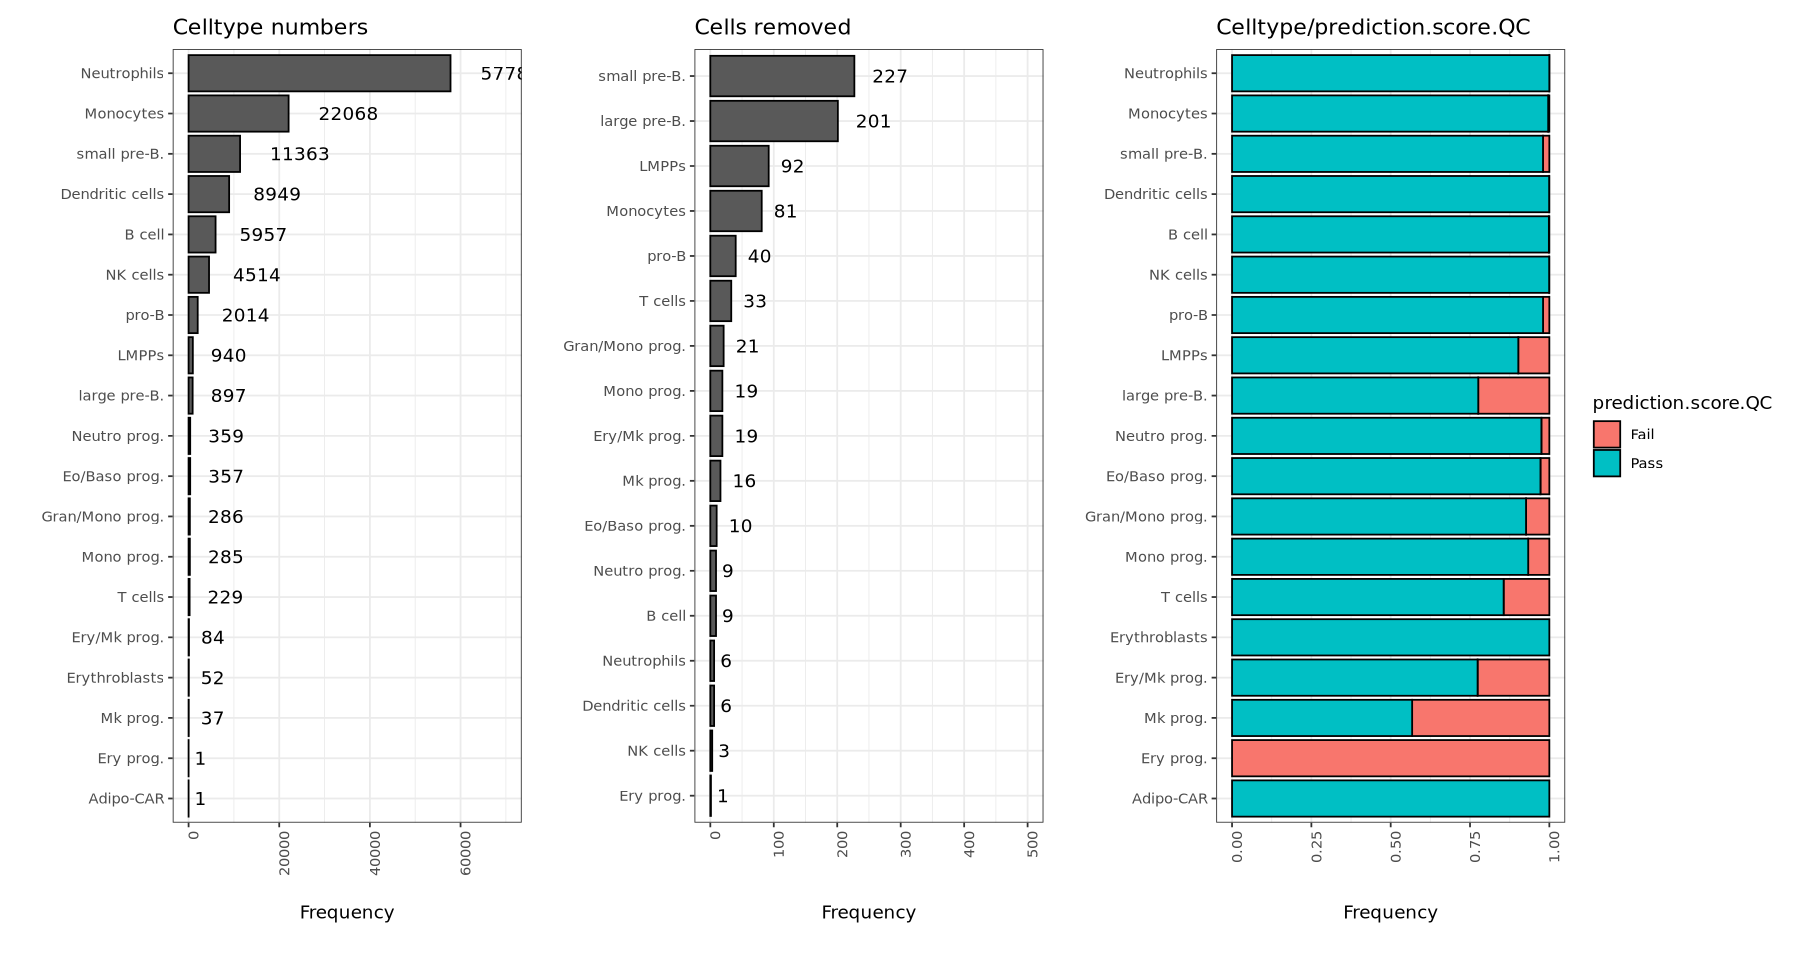

In [53]:
options(repr.plot.height = 8, repr.plot.width = 15)
gg1 + gg2 + gg3

In [54]:
adata$prediction.score.QC = reference.map.qc$prediction.score.QC[match(names(Idents(adata)), reference.map.qc$barcode)]

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



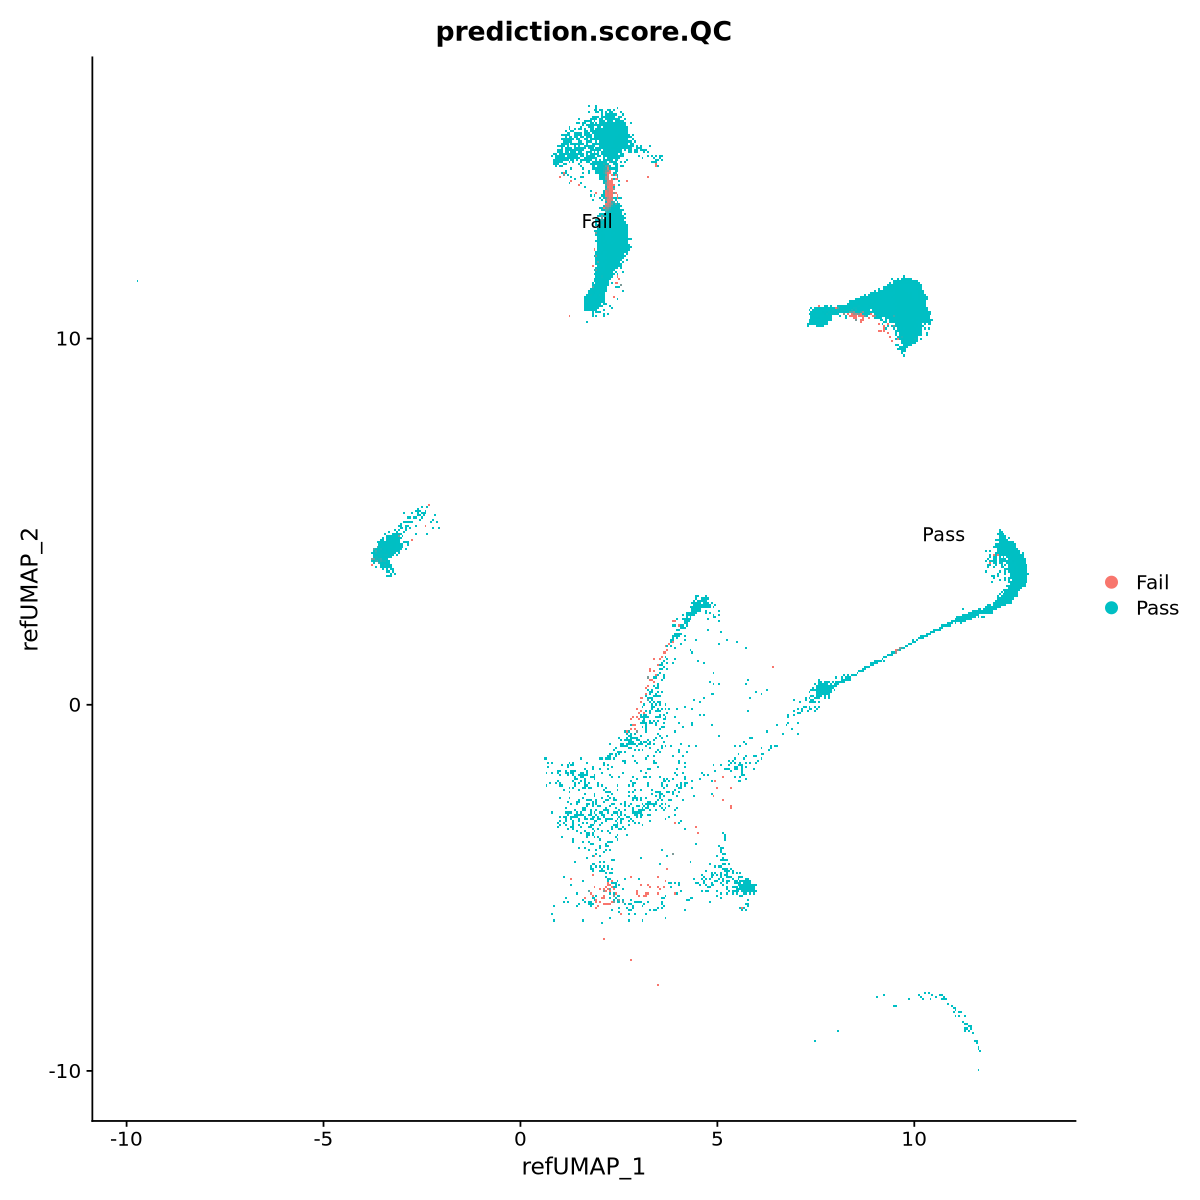

In [55]:
# visualize the results
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'ref.umap', 
              group.by = 'prediction.score.QC', label=TRUE, repel=TRUE)

In [56]:
# Clean it up
adata = subset(adata, cells = cells.remove$barcode, invert = TRUE)
## Also remove that random one cell cluster
adata = subset(adata, predicted.celltypes== "Adipo-CAR", invert = TRUE)

In [70]:
## Also remove that random one cell cluster
adata = subset(adata, predicted.celltypes== "Adipo-CAR", invert = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



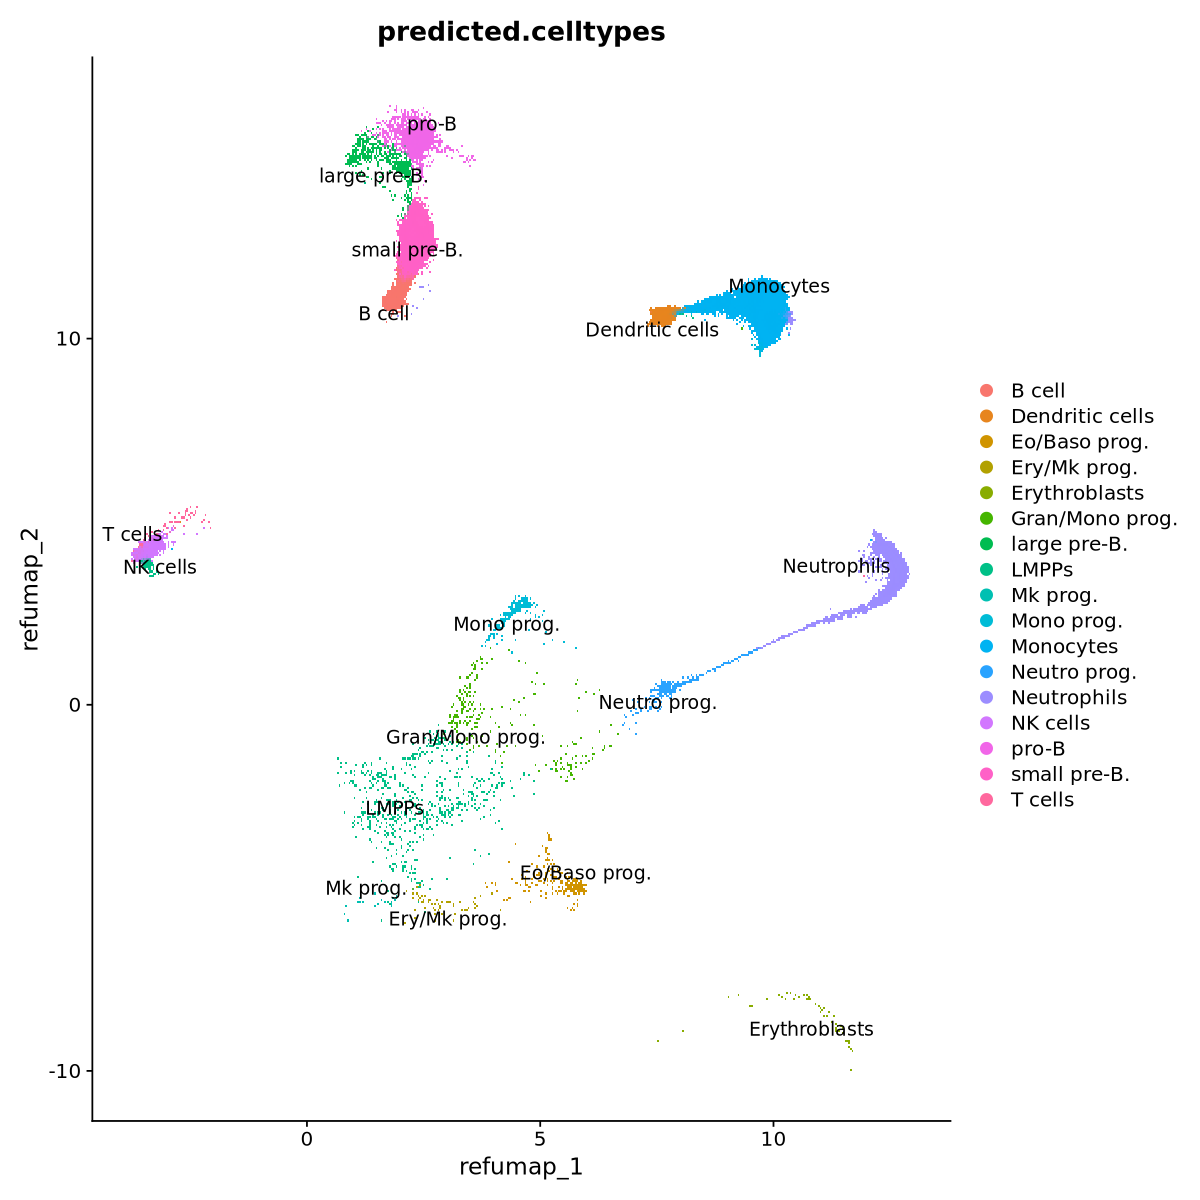

In [71]:
# visualize the results
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'ref.umap', 
              group.by = 'predicted.celltypes', label=TRUE, repel=TRUE)

In [72]:
# Celltypes frequencies
# Make table
table = data.frame(table(adata$predicted.celltypes))
colnames(table) = c("celltypes", "freq")
# Remove 0s
table = dplyr::filter(table, freq != 0)
max(table$freq)

options(repr.plot.width=12, repr.plot.height=8)
gg1 = ggplot(table, aes(x = reorder(celltypes, +freq), y = freq, label = freq)) +
  geom_bar(stat = "identity", color = "black") +
  theme_bw() +
  labs(title = "# of cells",
       x = "",
       y = " \n Frequency \n ") +
  ylim(0,70000)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  geom_text(hjust = -.5)+
  coord_flip()

[1] 57783

In [73]:
# Celltypes per condition
# Make table
table = data.frame(table(adata$predicted.celltypes, adata$condition))
colnames(table) = c("celltypes", "condition", "freq")
# Remove 0s
table = dplyr::filter(table, freq != 0)

In [74]:
options(repr.plot.width=12, repr.plot.height=8)
gg2 = ggplot(table, aes(x = reorder(celltypes, +freq), y = freq, fill = condition)) +
  geom_bar(stat = "identity", color = "black") +
  theme_bw() +
  labs(title = "Celltype/condition",
       x = "",
       y = " \n Frequency \n ") +
  ylim(0,70000)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  coord_flip()

In [75]:
options(repr.plot.width=12, repr.plot.height=8)
gg3 = ggplot(table, aes(x = reorder(celltypes, +freq), y = freq, fill = condition)) +
  geom_bar(stat = "identity", color = "black", position = position_fill()) +
  theme_bw() +
  labs(title = "Celltype/condition",
       x = "",
       y = " \n Frequency \n ") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  coord_flip()

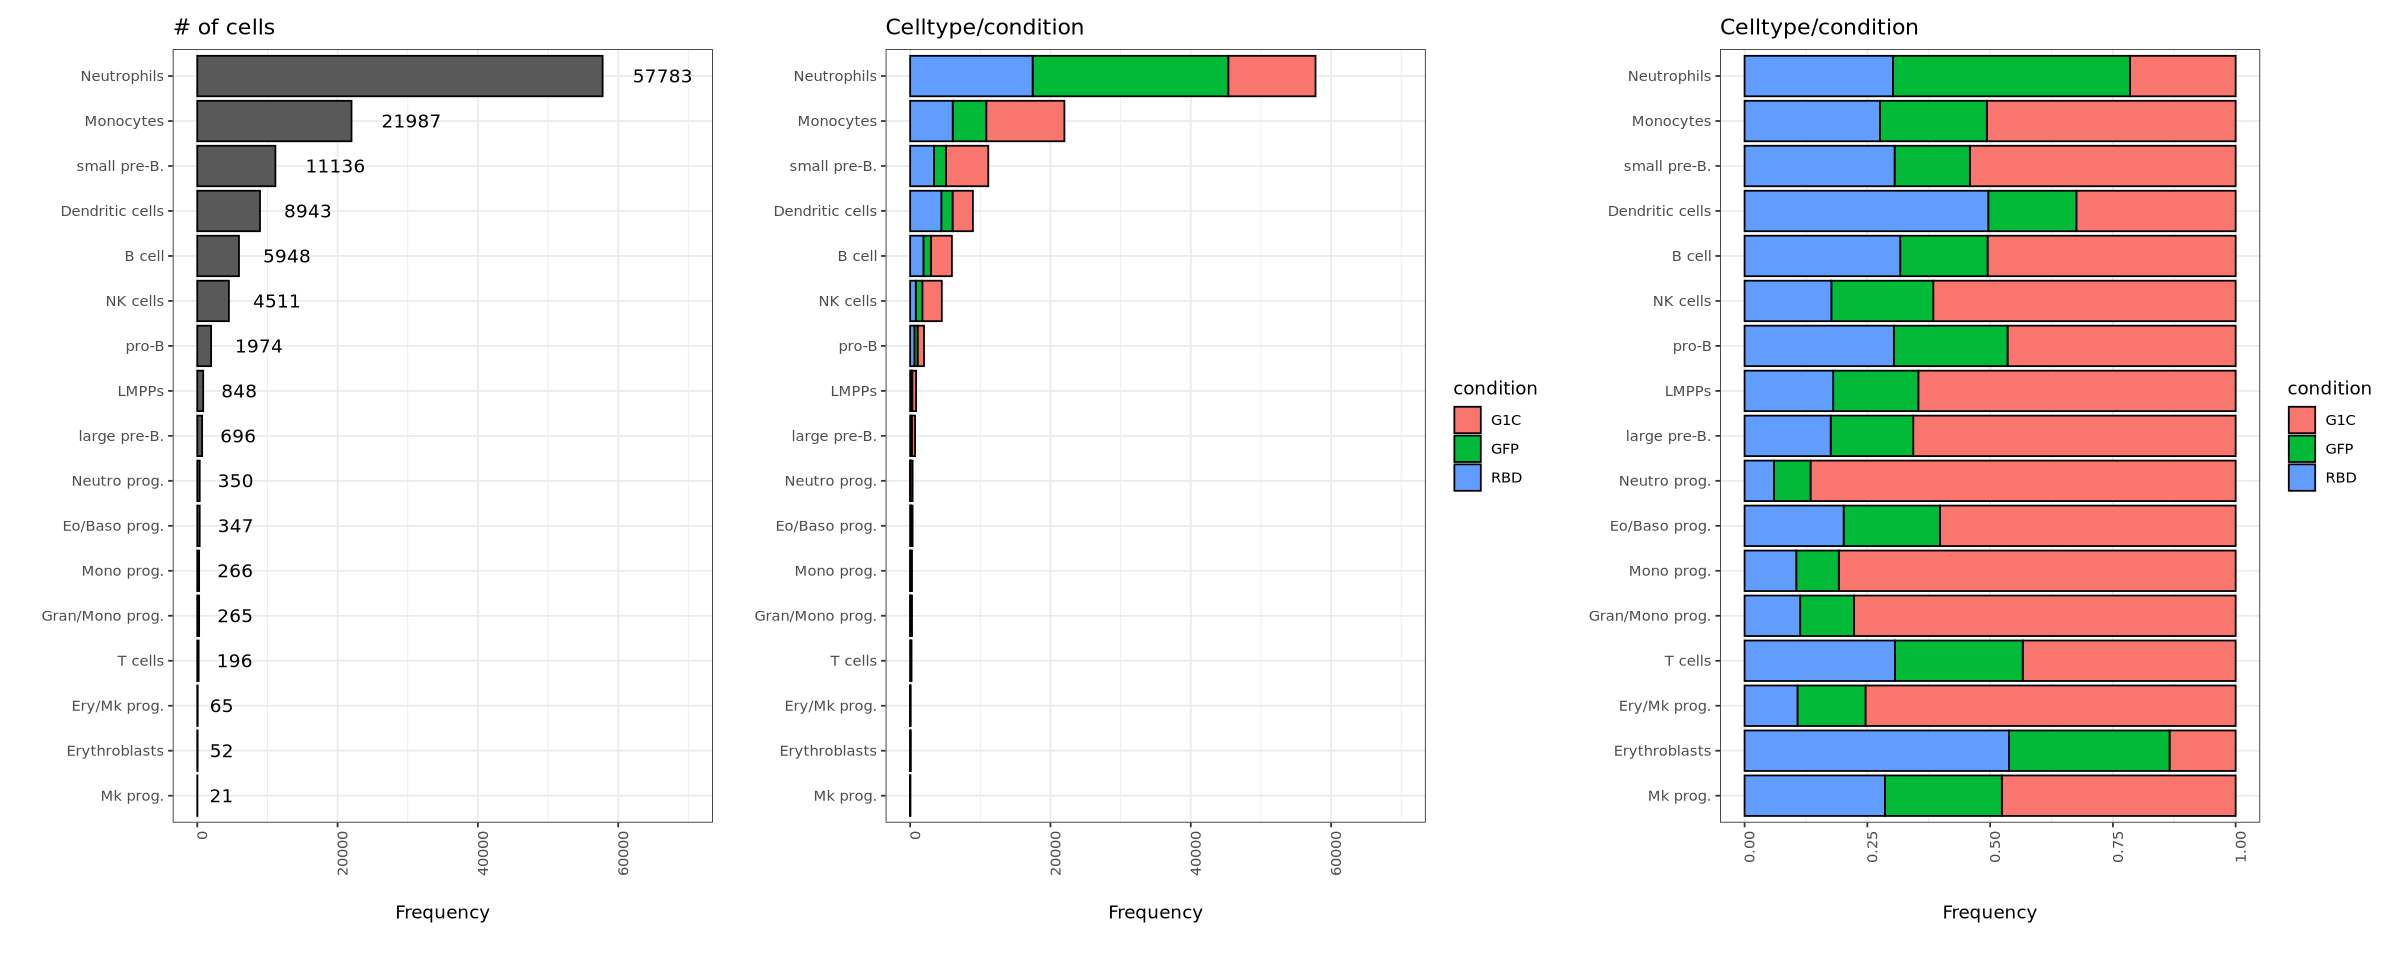

In [76]:
options(repr.plot.width=20, repr.plot.height=8)
gg1 + gg2 + gg3

In [77]:
# Save
file = paste(reference.map.dir, "snRNAseq_mrg.clean.refMapped.rds", sep = "")
saveRDS(adata, file = file)

## Map TSNE

In [ ]:
adata = RunTSNE(adata, reduction = "harmony", dims = 1:20)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



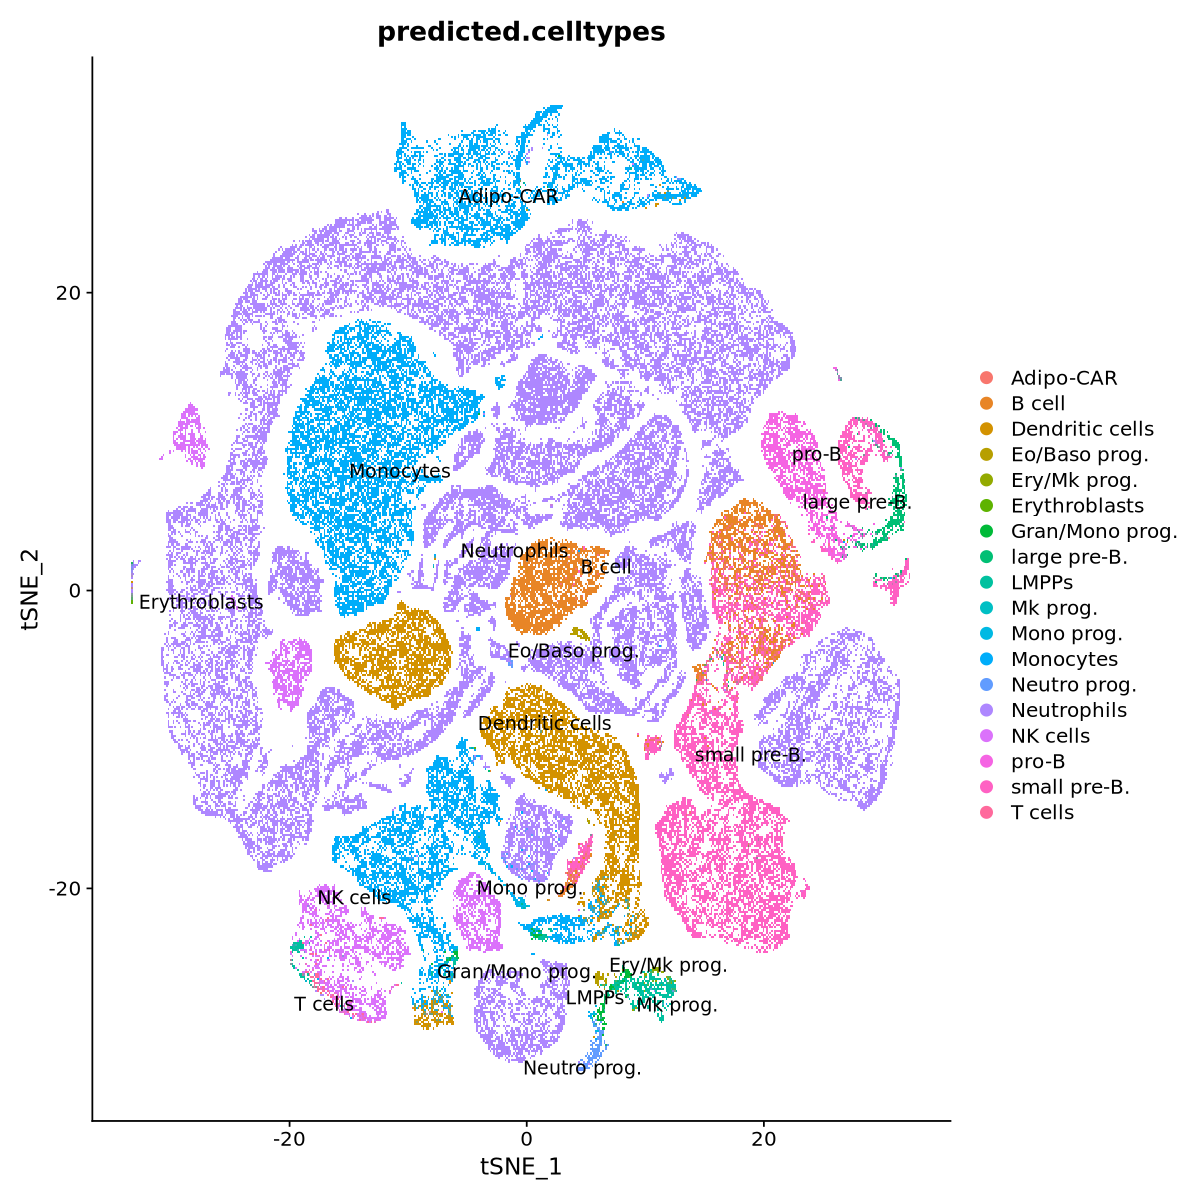

In [69]:
# visualize the results
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'tsne', 
              group.by = 'predicted.celltypes', label=TRUE, repel=TRUE)